In [1]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from src.vae_model import vae_model
from src.util import DataLoader, Pearson_correlation, AortaNormalizer
from src.visualiazation import plot_relative_error_aorta
import tensorflow as tf


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2024-11-25 13:48:29.082126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 13:48:29.851282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Load Data**

In [2]:
data_path = "../../../data/PulHypStudie_Check_npz_v2/"

In [3]:
data_loader = DataLoader(data_path)

Eit, Y, Pig = data_loader.load_data(10)

Data path: ../../../data/PulHypStudie_Check_npz_v2/ contains 10 pigs:
⋅ P_01_PulHyp
⋅ P_02_PulHyp
⋅ P_03_PulHyp
⋅ P_04_PulHyp
⋅ P_05_PulHyp
⋅ P_06_PulHyp
⋅ P_07_PulHyp
⋅ P_08_PulHyp
⋅ P_09_PulHyp
⋅ P_10_PulHyp
To load ['P_10_PulHyp']
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_10_PulHyp

Aorta curve min=45.03, max=139.87
Eit.shape=(6282, 64, 1024, 1), Y.shape=(6282, 1024, 1)


In [4]:
aorta_normalizer = AortaNormalizer()

In [5]:
Y_norm = aorta_normalizer.normalize_forward(Y)
Y_true = Y[:, :, 0]

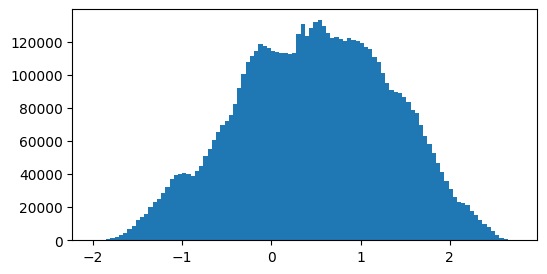

0.48439851141054713
0.7313283294877645


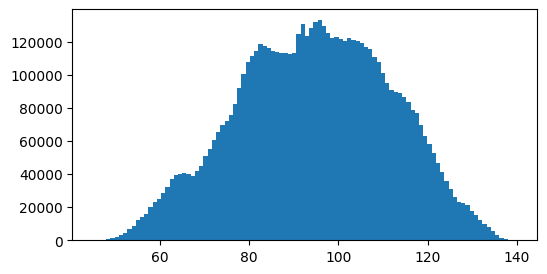

94.68797022821089
292.53133179510615


In [6]:
plt.figure(figsize=(6, 3))
plt.hist(Y_norm.flatten(), bins=100)
plt.show()
print(np.mean(Y_norm.flatten()))
print(np.var(Y_norm.flatten()))

plt.figure(figsize=(6, 3))
plt.hist(Y_true.flatten(), bins=100)
plt.show()
print(np.mean(Y_true.flatten()))
print(np.var(Y_true.flatten()))

**Test individual model**

2024-11-25 13:49:09.858478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1732538954.263495 1225343 service.cc:145] XLA service 0x778ad8004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732538954.263544 1225343 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-11-25 13:49:14.279855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CR

 80/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1732538958.653903 1225343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
Pearson correlation coefficient mean 0.9859845364395051
MAE 41750.149623838304
MSE 10737.486253045297
Pearson number 0.9859845364395051


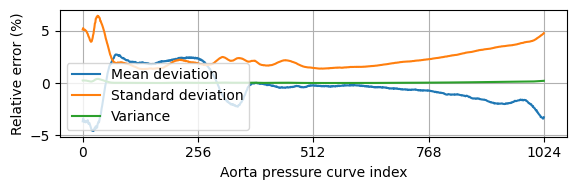

In [7]:
sel_model = "src/weights/vae_model_excl10_0.weights.h5"

rel_err_config = {
    "std": True,
    "var": True,
    "mean": True,
    "s_name": None,
}

vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.load_weights(sel_model)
# apply model
_, _, z = vae.encoder.predict(Y_norm)
Y_pred = vae.decoder.predict(z)[:, :, 0]

# inverse normalization
Y_pred = aorta_normalizer.normalize_inverse(Y_pred)


mae, mse, pn = plot_relative_error_aorta(Y_true, Y_pred, **rel_err_config)

In [8]:
Y_pred.shape

(6282, 1024)

In [9]:
from src.LaTeX_export import output_err_for_LaTeX, output_curve_for_LaTeX

In [10]:
output_err_for_LaTeX(Y_true, Y_pred, f_name="test_results.csv")

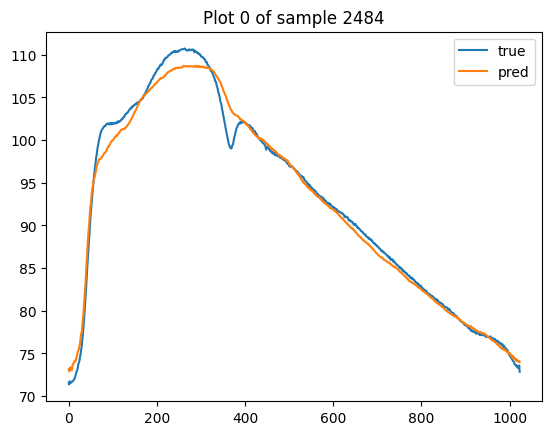

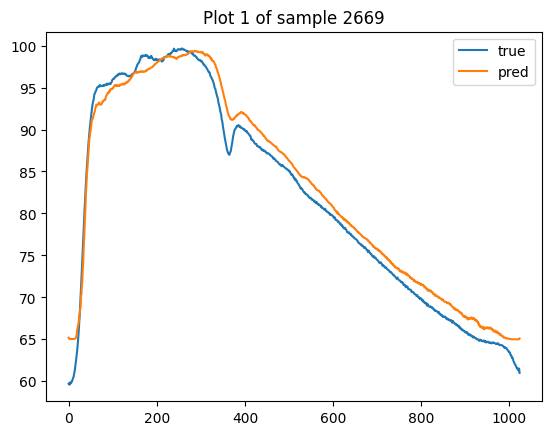

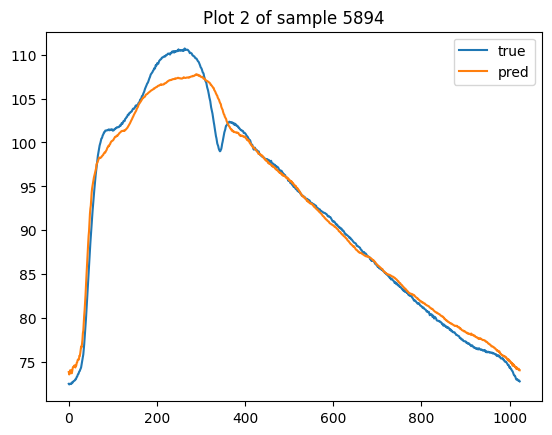

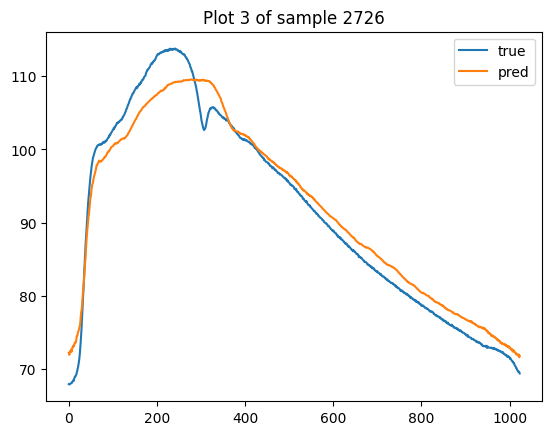

In [13]:
output_curve_for_LaTeX(Y_true, Y_pred, f_name="test_aorta.csv")

**Archive Code**

_Take batch size of 8 for training the final VAE network._

**Tuning parameter ...?**

**Export to LaTeX**

**Best Batch-Size**

In [ ]:
vae_models = glob("src/weights/vae_model*.weights.h5")
vae_models

In [ ]:
rel_err_config = {
    "std": True,
    "var": True,
    "mean": True,
    "s_name": None,
}

MAEs = list()
MSEs = list()
PNs = list()
for sel_model in vae_models:
    rel_err_config[
        "s_name"
    ] = f"images/rel_err{sel_model.split('/')[2].split('.')[0]}.png"
    print("load", sel_model)
    vae = vae_model()
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.load_weights(sel_model)
    # apply model
    _, _, z = vae.encoder.predict(Y)

    Y_pred = vae.decoder.predict(z)[:, :, 0]
    # inverse normalization
    Y_pred = aorta_normalizer.normalize_inverse(Y_pred)

    mae, mse, pn = plot_relative_error_aorta(Y_true, Y_pred, **rel_err_config)

    MAEs.append(mae)
    MSEs.append(mse)
    PNs.append(pn)


MAEs = np.array(MAEs)
MSEs = np.array(MSEs)
PNs = np.array(PNs)

In [ ]:
Y_pred

In [ ]:
Y_true

In [ ]:
print(f"{MAEs=}\n\n{MSEs=}\n\n{PNs=}")
best_choice = np.argmax(PNs)
print(
    "Best choice Batch size= ",
    np.argmin(MAEs),
    np.argmin(MSEs),
    best_choice,
    "\n\t",
    vae_models[best_choice],
)